A notebook for making a 100-frame movie from 3D dust for Linnea as a test

Two environment variables need to be set in bash: DROPBOX_ROOT, and FFMPEG_ROOT. The DROPBOX_ROOT folder is the path to the top level directory of the dust-holgrams folder shared by Josh. E.g. in bash,

export DROPBOX_ROOT='/Users/catherinezucker/Dropbox/dust-holograms/'

You can also set the path to the FFMPEG executable:

export FFMPEG_PATH='/usr/local/bin'

Ideally, you would set these in your bash_profile profile  (now called zprofile in the latest OS operating systems). Alternatively, if you want to set one of these variables locally in this notebook, you can use:

```
import os
os.environ['DROPBOX_ROOT'] = '/Users/catherinezucker/Dropbox/dust-holograms'
os.environ['FFMPEG_ROOT'] = '/Usr/local/bin'

```

First thing we need to do is figure out how to write some json

In [29]:
import json
import numpy as np
import os
%matplotlib inline
#%matplotlib notebook
from matplotlib import pyplot as plt
from astropy import table

Josh is having some trouble with ```.zprofile``` so:

In [30]:
if (os.environ.keys() != 'DROPBOX_HOME'):
    os.environ['DROPBOX_ROOT'] = '/Users/jegpeek/Dropbox/dust-holograms'
    os.environ['FFMPEG_ROOT'] = '/Users/jegpeek/'

Using a variable called ```run_name``` to record everything we need about the run

In [31]:
def define_paths(run_name):
    if os.path.isdir("{}/{}/".format(os.environ['DROPBOX_ROOT'],run_name)) == False:
        os.mkdir("{}/{}/".format(os.environ['DROPBOX_ROOT'],run_name))
        os.mkdir("{}/{}/frames/".format(os.environ['DROPBOX_ROOT'],run_name))

This is the camera properties, which we will fix.

In [32]:
arc = False
if arc:
    ec = "szyz"
if not arc:
    ec = "rxyz"

t = True
cprops ={
    "projection": "stereographic",
    "step_size": 1,
    "max_dist": 500.0,
    "fov": 45.0,
    "x_pix": 60,
    "y_pix": 40,
    "vmax": "auto",
    "clip_mode": "tanh",
    "fuzzy": t,
    "randomize_angles": t,
    "euler_convention": ec}

In [33]:
print(cprops)

{'projection': 'stereographic', 'step_size': 1, 'max_dist': 500.0, 'fov': 45.0, 'x_pix': 60, 'y_pix': 40, 'vmax': 'auto', 'clip_mode': 'tanh', 'fuzzy': True, 'randomize_angles': True, 'euler_convention': 'rxyz'}


_In arc mode_ Linnea asked for 100 frames orbiting around a point with equal distance. We'll assume that the middle of these 100 frames is the Sun, and we'll set some sweep out angle in the Galactic Plane.

In [34]:
nframes = 19 # 100 frames
if arc:
    angle_sweep = 45 # half of this CCW and half CW from the sun

In [35]:
def sweep(xc, yc, angle_sweep, nframes):
    R = np.sqrt(xc**2+ yc**2)
    phi =np.arctan2(yc, xc)*180/np.pi
    dangs = np.linspace(0, angle_sweep, nframes)
    xs = xc - R*np.cos((phi-angle_sweep/2+dangs)*np.pi/180)
    ys = yc - R*np.sin((phi-angle_sweep/2+dangs)*np.pi/180)
    angs = (dangs-angle_sweep/2+phi)*np.pi/180 ## wait are these in RADIANs??
    return xs, ys, angs

In [36]:
def plot_ang(x0, y0, xs, ys, run_name):
    plt.figure(figsize=[5, 5])
    plt.scatter(x0, y0)
    plt.scatter(0, 0, c='red')
    plt.plot(xs, ys)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title(run_name)
    plt.savefig('{}/{}/arc_{}'.format(os.environ['DROPBOX_ROOT'],run_name,run_name))

In track mode we'll move from one point to another while pointing at the cloud and keeping to top of the camera perpindicular to the plane that contains the track and cloud

Given the current position of the viewer, the unit direction toward the start of the track, and the cloud position, compute the angles of rotation

In [37]:
def determine_angles(v_pos, c_pos, t_hat):
    x_hat = np.array([1, 0, 0])
    y_hat = np.array([0, 1, 0])
    z_hat = np.array([0, 0, 1])
    # the vector to the cloud
    c_vec = c_pos-v_pos
    # the unit vector toward the cloud
    c_hat = c_vec/np.sqrt(np.sum(c_vec**2))
    
    #FIRST
    # the unit vector perp to the plane containing the track and the cloud
    n_OCT = np.cross(c_hat, t_hat) #CHECK ORDER ####FLIPPED
    n_hat_OCT = n_OCT/np.sqrt(np.sum(n_OCT**2))
    #print('n_hat_OCT', n_hat_OCT)
    #print('c_hat', c_hat)
    #print('v_pos', v_pos)
    #print('c_vec', c_vec)
    #print('c_pos', c_pos)
    # find the new orientation of the side of the camera
    v_y_prime = np.cross(n_hat_OCT, x_hat) #CHECK ORDER (correct)
    v_hat_y_prime = v_y_prime/np.sqrt(np.sum(v_y_prime**2))
    # and find the angle to rotate first
    theta = np.arccos(np.dot(v_hat_y_prime,y_hat))
    #print('theta', theta)
    #print('v_hat_y_prime',v_hat_y_prime)
    
    #SECOND
    # the unit vector perp to the plane that contains the rotation 
    #n_phi = np.cross(v_hat_y_prime, x_hat) #CHECK ORDER ###FLIPPED
    #n_hat_phi = n_phi/np.sqrt(np.sum(n_phi**2))
    # the vector being rotated to
    #v_x_prime_prime = np.cross(n_hat_OCT,n_hat_phi) #CHECK ORDER (correct)
    #### OOOPS
    v_x_prime_prime = np.cross(v_hat_y_prime, n_hat_OCT)
    v_hat_x_prime_prime = v_x_prime_prime/np.sqrt(np.sum(v_x_prime_prime**2))
    # and the angle rotated
    phi = np.arccos(np.dot(v_hat_x_prime_prime, x_hat))
    #print('n_phi', n_phi)
    
    #FINALLY
    zeta = np.arccos(np.dot(v_hat_x_prime_prime, c_hat))
    print('c hat', c_hat)
    return theta, phi, zeta
    

given some inputs build a track

In [38]:
def track(xt1, yt1, zt1, xt2, yt2, zt2, nframes):
    xts = np.linspace(xt1, xt2, nframes)
    yts = np.linspace(yt1, yt2, nframes)
    zts = np.linspace(zt1, zt2, nframes)
    t_vec = np.array([xt2-xt1, yt2-yt1, zt2-zt1])
    t_hat = t_vec/np.sqrt(np.sum(t_vec**2))
    return xts, yts, zts, t_hat

In [39]:
def build_fprops(fprops, cprops, angs, xs, ys, zc):
    for i in range(nframes):
        fprops.append({
          "xyz": [xs[i], ys[i], zc],
          "angles": [angs[i], 0.0, 0.0]
        })
    allprops = {"camera_props": cprops,"frame_props":fprops }
    return allprops

In [40]:
def build_fprops_track(fprops, cprops, theatas, phis, zetas, xs, ys, zs):
    for i in range(nframes):
        fprops.append({
          "xyz": [xs[i], ys[i], zs[i]],
          "angles": [thetas[i], phis[i], zetas[i]]
        })
    allprops = {"camera_props": cprops,"frame_props":fprops }
    return allprops

Let's read in a list of molecular clouds and make movies for each one:

In [41]:
clouds = table.Table.read('{}/Holo_Cloud_Targets.csv'.format(os.environ['DROPBOX_ROOT']))
#clouds = table.Table.read('{}/Holo_TEST_Targets.csv'.format(os.environ['DROPBOX_ROOT']))

In [42]:
makeimages = True
makemovies = True
oldzeta = 0
for c in clouds:
    print(c['cloud'])
    run_name = c['cloud'] + '_test_track_2'
    define_paths(run_name)
    if arc:
        xs, ys, angs = sweep(c['x'], c['y'], angle_sweep, nframes)
        print(xs, ys, angs)
        plot_ang(c['x'], c['y'], xs, ys, run_name)
        # we make an empty list of frames to which we can append frames
        fprops = []
        allprops = build_fprops(fprops, cprops, angs, xs, ys, np.float(c['z']))
    if not arc:
        #hardcoding a track
        #xts, yts, zts, t_hat = track(c['xt1'], c['yt1'], c['zt1'], c['xt2'], c['yt2'], c['zt2'], nframes)
        xts, yts, zts, t_hat = track(c['y']*0.5, c['x']*0.5, 0, c['y']*(-0.5), c['x']*(-0.5), 0, nframes)
        
        print(t_hat)
        fprops = []
        thetas = np.zeros(nframes)
        phis = np.zeros(nframes)
        zetas = np.zeros(nframes)
        for j in np.arange(nframes):
            v_pos = np.array([xts[j], yts[j], zts[j]])
            c_pos = np.array([c['x'], c['y'], c['z']])
            thetas[j], phis[j], zetas[j] = determine_angles(v_pos, c_pos, t_hat)
            print(thetas[j]*180/np.pi, phis[j]*180/np.pi, zetas[j]*180/np.pi,(zetas[j]-oldzeta)*180/np.pi )
            oldzeta = zetas[j]
        allprops = build_fprops_track(fprops, cprops, thetas, phis, zetas, xts, yts, zts)

    with open('{}/{}/{}.json'.format(os.environ['DROPBOX_ROOT'],run_name,run_name), 'w') as outfile:
        json.dump(allprops, outfile,indent=2)
    if makeimages:
        os.system("python3 project_frames.py {}/{}/{}.json {}/leike2020_bayestar19_splice.npy {}/{}/frames/{}_{{:05d}}.png"
          .format(os.environ['DROPBOX_ROOT'],run_name,run_name,os.environ['DROPBOX_ROOT'],os.environ['DROPBOX_ROOT'],run_name, run_name))
    if makemovies:
        os.system("{}/ffmpeg -y -r 30 -start_number 0 -i {}/{}/frames/{}_%05d.png -c:v libx264 -s 600x400 -r 30 -pix_fmt yuv420p {}/{}/{}.mp4"
          .format(os.environ['FFMPEG_ROOT'],os.environ['DROPBOX_ROOT'],run_name,run_name,os.environ['DROPBOX_ROOT'],run_name, run_name))


Chamaeleon
[ 0.87415728 -0.48564293  0.        ]
c hat [ 0.62485057 -0.75639806 -0.19345219]
25.299589809325603 13.355740562576404 50.042466908587876 50.042466908587876
c hat [ 0.61295617 -0.76430337 -0.20031247]
25.299589809325603 13.355740562576404 50.95027419762971 0.9078072890418311
c hat [ 0.60001952 -0.77257416 -0.20761921]
25.299589809325603 13.355740562576404 51.92456884864203 0.9742946510123224
c hat [ 0.58591426 -0.78121902 -0.21540966]
25.299589809325603 13.355740562576404 52.97230219059096 1.047733341948931
c hat [ 0.57049558 -0.79024203 -0.22372376]
25.299589809325603 13.355740562576404 54.10131594420795 1.1290137536169835
c hat [ 0.55359742 -0.79964072 -0.23260396]
25.29958980932562 13.355740562576404 55.32046227655706 1.2191463323491114
c hat [ 0.53502933 -0.80940334 -0.24209472]
25.29958980932562 13.355740562576404 56.6397351963399 1.3192729197828437
c hat [ 0.51457302 -0.81950518 -0.25224168]
25.299589809325603 13.355740562576404 58.07041070830708 1.43067551196718
c ha

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.01700275445223815
frame 1: vmax = 0.01713246413295201
frame 2: vmax = 0.01612155674179303
frame 3: vmax = 0.016972325444265152
frame 4: vmax = 0.02092301001121814
frame 5: vmax = 0.01581444806377476
frame 6: vmax = 0.014838199435180286
frame 7: vmax = 0.022366495597896573
frame 8: vmax = 0.01863552903847085
frame 9: vmax = 0.024053258913525496
frame 10: vmax = 0.030623549132142217
frame 11: vmax = 0.03118580337156891
frame 12: vmax = 0.023769708298612385
frame 13: vmax = 0.02289906782549224
frame 14: vmax = 0.029704070878287893
frame 15: vmax = 0.02343760833160195
frame 16: vmax = 0.02696299780299887
frame 17: vmax = 0.020467164842935745
frame 18: vmax = 0.012805676443269477
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Ophiuchus
[ 0.07728751 -0.99700885  0.        ]
c hat [ 0.84702891 -0.47092279  0.24652334]
178.64934316482677 16.912880738655456 27.70899823066707 -58.17050614102316
c hat [ 0.86386381 -0.43588798  0.25246977]
178.64934316482677 16.912880738655456 25.455874365086974 -2.253123865580099
c hat [ 0.88006881 -0.39845925  0.25828107]
178.64934316482677 16.912880738655456 23.095230166119197 -2.3606441989677736
c hat [ 0.89541001 -0.35861509  0.26388658]
178.64934316482677 16.912880738655456 20.627771884024718 -2.467458282094484
c hat [ 0.90963298 -0.31637741  0.26920841]
178.64934316482677 16.912880738655456 18.055851703691328 -2.5719201803333878
c hat [ 0.92246878 -0.27181976  0.27416303]
178.64934316482706 16.912880738655456 15.383702700159589 -2.6721490035317372
c hat [ 0.93364235 -0.22507449  0.27866366]
178.64934316482677 16.912880738655456 12.617629650204636 -2.766073049954954
c hat [ 0.94288334 -0.1763377   0.28262344]
178.64934316482677 16.912880738655456 9.766128714650328 -2.8515009

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.007072618604928721
frame 1: vmax = 0.00616974423348438
frame 2: vmax = 0.0062886851529328856
frame 3: vmax = 0.005649623862351291
frame 4: vmax = 0.028544865185933306
frame 5: vmax = 0.02315761571683106
frame 6: vmax = 0.01642720404645661
frame 7: vmax = 0.026506089670961956
frame 8: vmax = 0.015936189262909465
frame 9: vmax = 0.017692481088015483
frame 10: vmax = 0.03288181691755017
frame 11: vmax = 0.018337942735568505
frame 12: vmax = 0.018433809664275033
frame 13: vmax = 0.01977315225095663
frame 14: vmax = 0.015585012282739627
frame 15: vmax = 0.0058103344714909326
frame 16: vmax = 0.005863182719243924
frame 17: vmax = 0.00764119492363534
frame 18: vmax = 0.005495798560063122
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Lupus
[ 0.31073886 -0.95049533  0.        ]
c hat [ 0.81349044 -0.57818329  0.06274857]
178.1184964096876 5.734923978005336 35.15647328356763 12.010622058250075
c hat [ 0.8276761  -0.55744603  0.06485522]
178.1184964096876 5.7349239780052725 33.71182585689949 -1.4446474266681437
c hat [ 0.84225504 -0.53489183  0.06706106]
178.1184964096876 5.7349239780052725 32.16786958759563 -1.5439562693038555
c hat [ 0.85717121 -0.51033893  0.06936646]
178.1184964096876 5.734923978005336 30.51648907486113 -1.651380512734502
c hat [ 0.87234597 -0.48359238  0.07176989]
178.1184964096876 5.7349239780052725 28.74911793534871 -1.7673711395124199
c hat [ 0.88767287 -0.45444607  0.07426745]
178.1184964096876 5.7349239780052725 26.856831610466443 -1.8922863248822677
c hat [ 0.90301165 -0.42268631  0.07685206]
178.1184964096876 5.7349239780052725 24.830494868447136 -2.0263367420193052
c hat [ 0.91818193 -0.38809752  0.07951266]
178.1184964096876 5.7349239780052725 22.660979947604122 -2.1695149208430125
c hat

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.006415546247710154
frame 1: vmax = 0.007540846989009879
frame 2: vmax = 0.007379691350710345
frame 3: vmax = 0.006255510477982171
frame 4: vmax = 0.006887043418024405
frame 5: vmax = 0.005731924250703742
frame 6: vmax = 0.006143766582645185
frame 7: vmax = 0.006531406606132805
frame 8: vmax = 0.00564581718302361
frame 9: vmax = 0.006245861211573356
frame 10: vmax = 0.007735254116632859
frame 11: vmax = 0.021224666085618082
frame 12: vmax = 0.02070348405673576
frame 13: vmax = 0.028708083842881024
frame 14: vmax = 0.022807600765503595
frame 15: vmax = 0.0210096879684279
frame 16: vmax = 0.024564687362115364
frame 17: vmax = 0.006507581205296447
frame 18: vmax = 0.006580964985390892
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Taurus
[-0.12663189  0.99194978  0.        ]
c hat [-0.84045484  0.49586836 -0.21851826]
177.94424625705352 15.695210434490745 150.8097877572202 138.99091637853667
c hat [-0.85698571  0.46396094 -0.2243117 ]
177.94424625705352 15.695210434490745 152.8954350603871 2.0856473031668705
c hat [-0.87316478  0.42969934 -0.23009072]
177.94424625705352 15.695210434490745 155.09158846789438 2.196153407507317
c hat [-0.88878962  0.39300221 -0.23580133]
177.94424625705352 15.695210434490745 157.400292082505 2.308703614610585
c hat [-0.90363028  0.35381871 -0.24138069]
177.94424625705352 15.695210434490745 159.82234390477308 2.4220518222680845
c hat [-0.91743165  0.31213766 -0.24675748]
177.94424625705352 15.695210434490745 162.3570045044864 2.5346605997133547
c hat [-0.92991809  0.26799723 -0.25185281]
177.94424625705352 15.695210434490745 165.00170602155524 2.644701517068832
c hat [-0.94080078  0.22149389 -0.25658203]
177.94424625705352 15.695210434490745 167.75178470405845 2.750078682503204
c ha

100% (19 of 19) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.010090306006044557
frame 1: vmax = 0.011255774050798209
frame 2: vmax = 0.01901216573716374
frame 3: vmax = 0.01865586806419742
frame 4: vmax = 0.010362978512213886
frame 5: vmax = 0.01354930191837775
frame 6: vmax = 0.014837548336796317
frame 7: vmax = 0.021605920105313998
frame 8: vmax = 0.01517553689129818
frame 9: vmax = 0.02200565573854874
frame 10: vmax = 0.011268491941624234
frame 11: vmax = 0.017428107151647054
frame 12: vmax = 0.011292948760996296
frame 13: vmax = 0.018808356061615995
frame 14: vmax = 0.01767819348980811
frame 15: vmax = 0.02134775511585758
frame 16: vmax = 0.01712080194880218
frame 17: vmax = 0.017805254414186494
frame 18: vmax = 0.01593381165710889
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Perseus
[-0.3582515   0.93362512  0.        ]
c hat [-0.77670029  0.57589485 -0.25511131]
170.0096413763033 24.328001692504355 148.47267128960965 -10.07971426851965
c hat [-0.78752067  0.55717522 -0.26337612]
170.0096413763033 24.328001692504355 149.79896157636725 1.3262902867576198
c hat [-0.79859391  0.53688495 -0.27203368]
170.0096413763033 24.328001692504337 151.21324631900856 1.414284742641307
c hat [-0.80987519  0.51486911 -0.2810907 ]
170.0096413763033 24.328001692504337 152.7226766723981 1.509430353389541
c hat [-0.82130355  0.49096021 -0.29054872]
170.0096413763033 24.328001692504355 154.33486748611435 1.612190813716249
c hat [-0.83279829  0.46497904 -0.30040224]
170.0096413763033 24.328001692504323 156.05785161153437 1.7229841254200469
c hat [-0.84425478  0.43673653 -0.31063655]
170.0096413763033 24.328001692504337 157.8999984133768 1.842146801842414
c hat [-0.8555399   0.4060369  -0.32122502]
170.0096413763033 24.328001692504337 159.8698847654135 1.9698863520367045
c hat [-0

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.010411457901416725
frame 1: vmax = 0.011257109299018339
frame 2: vmax = 0.011295414856824209
frame 3: vmax = 0.01016063441708684
frame 4: vmax = 0.011188127783672825
frame 5: vmax = 0.013571587714603085
frame 6: vmax = 0.013715173392967699
frame 7: vmax = 0.01563126678628032
frame 8: vmax = 0.015512490480978159
frame 9: vmax = 0.0157360870588509
frame 10: vmax = 0.01810689712659587
frame 11: vmax = 0.01474718787124948
frame 12: vmax = 0.02095594866407191
frame 13: vmax = 0.017394890013862095
frame 14: vmax = 0.01445276030774039
frame 15: vmax = 0.014745009365569786
frame 16: vmax = 0.01838389447332156
frame 17: vmax = 0.015623789305162063
frame 18: vmax = 0.02476088266779334
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Musca
[ 0.85749293 -0.51449576  0.        ]
c hat [ 0.64182902 -0.75852521 -0.11267218]
16.78983037118476 9.83266236008286 49.35294275621152 -119.0237240297554
c hat [ 0.63182602 -0.76625708 -0.11681596]
16.78983037118476 9.83266236008286 50.11524705121553 0.7623042950040082
c hat [ 0.62093634 -0.77442622 -0.12125219]
16.789830371184735 9.832662360082823 50.935604841533284 0.8203577903177566
c hat [ 0.6090469 -0.7830603 -0.1260097]
16.789830371184735 9.83266236008286 51.820532020095875 0.8849271785625863
c hat [ 0.59602631 -0.79218687 -0.13112058]
16.789830371184735 9.83266236008286 52.77748748815901 0.9569554680631419
c hat [ 0.58172145 -0.80183227 -0.13662051]
16.78983037118476 9.832662360082823 53.81503306131411 1.0375455731550995
c hat [ 0.56595337 -0.81202006 -0.14254898]
16.789830371184735 9.83266236008286 54.94302169244837 1.1279886311342608
c hat [ 0.54851241 -0.82276861 -0.14894949]
16.789830371184735 9.832662360082823 56.172817868198834 1.2297961757504556
c hat [ 0.52915244 -

100% (19 of 19) |########################| Elapsed Time: 0:00:06 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.01940434735933377
frame 1: vmax = 0.017148229707549034
frame 2: vmax = 0.017882401355298498
frame 3: vmax = 0.019493928588686687
frame 4: vmax = 0.019494586337885266
frame 5: vmax = 0.017015756036595123
frame 6: vmax = 0.02558033493765106
frame 7: vmax = 0.020787513672668866
frame 8: vmax = 0.018363817382985873
frame 9: vmax = 0.020229078297685193
frame 10: vmax = 0.016825090674654347
frame 11: vmax = 0.02489357815978292
frame 12: vmax = 0.01745573273912305
frame 13: vmax = 0.025790499119786547
frame 14: vmax = 0.02712681161890214
frame 15: vmax = 0.02219477823979105
frame 16: vmax = 0.027952580707889866
frame 17: vmax = 0.028508640457381263
frame 18: vmax = 0.028398886559705717
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Pipe
[-0.03309444 -0.99945223  0.        ]
c hat [ 0.90169901 -0.42807933  0.06072047]
179.87421916167978 3.79302749321759 25.35411704391662 -56.68716739241696
c hat [ 0.9210416  -0.38451251  0.0619072 ]
179.87421916167978 3.79302749321759 22.621857735291734 -2.7322593086248848
c hat [ 0.93889401 -0.33839378  0.06298954]
179.87421916167978 3.79302749321759 19.787414789838106 -2.8344429454536275
c hat [ 0.95492221 -0.2898871   0.06394568]
179.87421916167978 3.79302749321759 16.859559246480647 -2.9278555433574605
c hat [ 0.96880069 -0.23923225  0.06475459]
179.87421916167978 3.79302749321759 13.849586343376934 -3.009972903103713
c hat [ 0.98022933 -0.18674495  0.06539706]
179.87421916167978 3.79302749321759 10.771230727571409 -3.078355615805527
c hat [ 0.98895096 -0.13281139  0.06585689]
179.87421916167978 3.79302749321759 7.64042155413358 -3.130809173437827
c hat [ 0.99476785 -0.07787695  0.06612194]
179.87421916167978 3.79302749321759 4.474874662629714 -3.1655468915038663
c hat [ 0.997

100% (19 of 19) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.00800114735988609
frame 1: vmax = 0.013183021003409522
frame 2: vmax = 0.02565225169619953
frame 3: vmax = 0.022119871961156605
frame 4: vmax = 0.024421348429008505
frame 5: vmax = 0.025510872748782276
frame 6: vmax = 0.022940100479288957
frame 7: vmax = 0.017900550952283083
frame 8: vmax = 0.013989420084166341
frame 9: vmax = 0.026936269772595552
frame 10: vmax = 0.028107628841520637
frame 11: vmax = 0.023200528844434302
frame 12: vmax = 0.027974668147813644
frame 13: vmax = 0.006262844532044255
frame 14: vmax = 0.0065027211884444115
frame 15: vmax = 0.006330060264386703
frame 16: vmax = 0.006889266206693719
frame 17: vmax = 0.005712012172734831
frame 18: vmax = 0.006636559145015781
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Cepheus
[-0.92722167  0.37451299  0.        ]
c hat [-0.58895664  0.78315315  0.19950243]
20.09652816130145 7.901277263702785 126.48423258993904 98.86849072865132
c hat [-0.57134829  0.79437887  0.20621188]
20.09652816130145 7.901277263702785 125.22749854165616 -1.2567340482828655
c hat [-0.55222038  0.80595689  0.2132748 ]
20.09652816130145 7.901277263702785 123.88399223919548 -1.3435063024606881
c hat [-0.53141182  0.81785766  0.22070417]
20.09652816130145 7.901277263702785 122.44604697360313 -1.4379452655923495
c hat [-0.50874538  0.83003693  0.22851001]
20.09652816130145 7.901277263702785 120.90535867367451 -1.5406882999286258
c hat [-0.48402759  0.84243184  0.23669789]
20.09652816130145 7.901277263702785 119.25299178268298 -1.652366890991521
c hat [-0.45704928  0.85495612  0.24526717]
20.09652816130145 7.901277263702785 117.47941564185 -1.7735761408329862
c hat [-0.42758742  0.86749464  0.25420868]
20.09652816130145 7.901277263702785 115.57458449737278 -1.9048311444772328
c hat [-

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.00710151486389077
frame 1: vmax = 0.005738783024717122
frame 2: vmax = 0.0054990876015890535
frame 3: vmax = 0.005438942461765691
frame 4: vmax = 0.006779861474127756
frame 5: vmax = 0.008171929966743846
frame 6: vmax = 0.006079723190447112
frame 7: vmax = 0.006507964085809363
frame 8: vmax = 0.008335583636850061
frame 9: vmax = 0.009944577817408573
frame 10: vmax = 0.011843153687772428
frame 11: vmax = 0.010725381350759563
frame 12: vmax = 0.01223958300719096
frame 13: vmax = 0.015408081577697885
frame 14: vmax = 0.01130163585983246
frame 15: vmax = 0.015029717280776822
frame 16: vmax = 0.01742052778408106
frame 17: vmax = 0.017952680517511907
frame 18: vmax = 0.013830440622521565
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Corona_Australis
[-0.10967912 -0.99396705  0.        ]
c hat [ 0.8423754  -0.34740299 -0.41196461]
177.04527816889095 25.03928188925152 21.603207068440295 -61.9209143367563
c hat [ 0.8576412  -0.30131472 -0.41672655]
177.04527816889095 25.03928188925153 18.807829385444816 -2.795377682995477
c hat [ 0.87112025 -0.25352459 -0.42056486]
177.04527816889095 25.03928188925153 15.954047093446317 -2.8537822919985003
c hat [ 0.8826022  -0.20432557 -0.42339628]
177.04527816889095 25.03928188925153 13.054551093581976 -2.8994959998643393
c hat [ 0.89191255 -0.15405762 -0.42515673]
177.04527816889095 25.03928188925152 10.123369875298575 -2.931181218283401
c hat [ 0.89892209 -0.10309711 -0.4258052 ]
177.04527816889095 25.03928188925153 7.175496996730761 -2.9478728785678157
c hat [ 0.90355397 -0.05184326 -0.42532634]
177.04527816889095 25.03928188925152 4.226447081161936 -2.949049915568825
c hat [ 9.05787570e-01 -7.02705640e-04 -4.23731501e-01]
177.04527816889095 25.039281889251498 1.2917718279374262

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.03555605543454294
frame 1: vmax = 0.03017315194597177
frame 2: vmax = 0.024494110251544046
frame 3: vmax = 0.02439607054453518
frame 4: vmax = 0.026170617483410753
frame 5: vmax = 0.028816464017989346
frame 6: vmax = 0.027450265012084855
frame 7: vmax = 0.020987451474349654
frame 8: vmax = 0.01698550607523066
frame 9: vmax = 0.02559314971938875
frame 10: vmax = 0.018586067737298435
frame 11: vmax = 0.03281518640855211
frame 12: vmax = 0.007754896736776573
frame 13: vmax = 0.006506754001951776
frame 14: vmax = 0.005891261585318716
frame 15: vmax = 0.006408483431994683
frame 16: vmax = 0.005969331170010264
frame 17: vmax = 0.006466283054935048
frame 18: vmax = 0.005985351316849119
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Orion_A
[0.53636501 0.84398612 0.        ]
c hat [-0.83934387 -0.16671899 -0.51740376]
155.85084247957096 32.77149443840607 176.58610108081652 149.88731315075844
c hat [-0.84083298 -0.22389764 -0.49281817]
155.85084247957096 32.77149443840607 179.84619829258594 3.26009721176945
c hat [-0.83936764 -0.27496526 -0.46888813]
155.85084247957099 32.77149443840607 176.61340575157325 -3.232792541012707
c hat [-0.83573939 -0.32042182 -0.4459479 ]
155.85084247957099 32.77149443840607 173.68835469582746 -2.925051055745805
c hat [-0.83058088 -0.36082612 -0.42419326]
155.85084247957099 32.77149443840607 171.04233119443987 -2.6460235013875635
c hat [-0.82438344 -0.39674076 -0.40371861]
155.85084247957099 32.771494438406066 168.64702809526636 -2.3953030991735176
c hat [-0.81752033 -0.42869969 -0.38454789]
155.85084247957096 32.77149443840607 166.47570428906337 -2.1713238062029876
c hat [-0.81027002 -0.45719146 -0.3666585 ]
155.85084247957099 32.771494438406066 164.50378396327895 -1.9719203257844335
c

100% (19 of 19) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.010152056612801972
frame 1: vmax = 0.01060847238694987
frame 2: vmax = 0.01014980376321182
frame 3: vmax = 0.010756473412737251
frame 4: vmax = 0.012295592380309245
frame 5: vmax = 0.012110656422428293
frame 6: vmax = 0.015360622725816939
frame 7: vmax = 0.015017249042539333
frame 8: vmax = 0.016757776057555022
frame 9: vmax = 0.01865887861219926
frame 10: vmax = 0.017656811397633646
frame 11: vmax = 0.01960080547477628
frame 12: vmax = 0.015542598477029969
frame 13: vmax = 0.010217069134738268
frame 14: vmax = 0.010109378896417184
frame 15: vmax = 0.008408363727379764
frame 16: vmax = 0.013474535857563752
frame 17: vmax = 0.008090614913868194
frame 18: vmax = 0.005941995989989664
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Orion_B
[0.42973499 0.90295506 0.        ]
c hat [-0.94029364  0.02971188 -0.33906499]
170.40364234006736 19.304398141508074 175.07680286088663 23.94711059534893
c hat [-0.94362807 -0.03766978 -0.32885721]
170.40364234006736 19.30439814150809 178.98696729619147 3.9101644353048335
c hat [-0.94276428 -0.10068533 -0.31789618]
170.40364234006736 19.304398141508074 177.34733598535163 -1.639631310839824
c hat [-0.93848609 -0.15904759 -0.30650893]
170.40364234006736 19.304398141508074 173.9310569393563 -3.4162790459953345
c hat [-0.93153331 -0.21269504 -0.29496866]
170.40364234006736 19.30439814150809 170.76143058535305 -3.1696263540032708
c hat [-0.9225657  -0.26173459 -0.28349168]
170.40364234006736 19.304398141508074 167.83004326853552 -2.931387316817504
c hat [-0.91214668 -0.30638773 -0.2722407 ]
170.40364234006736 19.304398141508074 165.1247005416804 -2.705342726855152
c hat [-0.90074113 -0.34694549 -0.26133167]
170.40364234006736 19.304398141508074 162.63096861248547 -2.4937319291949205

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.00871855200696882
frame 1: vmax = 0.010157667331106495
frame 2: vmax = 0.011793062833799923
frame 3: vmax = 0.011268548139662016
frame 4: vmax = 0.011530638038631878
frame 5: vmax = 0.013491010480083788
frame 6: vmax = 0.014911239076980564
frame 7: vmax = 0.01924397731603676
frame 8: vmax = 0.021549703063572453
frame 9: vmax = 0.014157153084099264
frame 10: vmax = 0.011028769297203325
frame 11: vmax = 0.012176068943837891
frame 12: vmax = 0.015450691090667533
frame 13: vmax = 0.01082498886452231
frame 14: vmax = 0.008893341296945436
frame 15: vmax = 0.015351489567852697
frame 16: vmax = 0.009980946522828162
frame 17: vmax = 0.007443032410599699
frame 18: vmax = 0.005564813944751223
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

Orion_Lambda
[0.24695428 0.96902713 0.        ]
c hat [-0.92301872  0.25932431 -0.28423116]
175.81151351775102 15.991980842182182 163.77612038806527 18.71704582749153
c hat [-0.93759893  0.20047238 -0.28411103]
175.81151351775102 15.991980842182182 167.25056612460784 3.47444573654258
c hat [-0.94869008  0.1411529  -0.28295403]
175.81151351775102 15.991980842182182 170.7093811576401 3.4588150330322587
c hat [-0.95625593  0.08201993 -0.28079766]
175.81151351775102 15.991980842182182 174.1278104555428 3.418429297902698
c hat [-0.96037269  0.02369916 -0.27770963]
175.81151351775102 15.991980842182182 177.48280777937094 3.3549973238281323
c hat [-0.96121705 -0.03324274 -0.27378221]
175.81151351775102 15.991980842182182 179.24610842175153 1.7633006423806112
c hat [-0.95904697 -0.0883211  -0.26912504]
175.81151351775102 15.991980842182182 176.0762455976673 -3.1698628240842575
c hat [-0.95417858 -0.1411471  -0.26385743]
175.81151351775102 15.991980842182182 173.02140347147756 -3.05484212618975

100% (19 of 19) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.008313411771443497
frame 1: vmax = 0.008800822657060054
frame 2: vmax = 0.010668271366306726
frame 3: vmax = 0.009088705524271063
frame 4: vmax = 0.015486301583128807
frame 5: vmax = 0.012262701198338619
frame 6: vmax = 0.01722238353514331
frame 7: vmax = 0.014438065894390093
frame 8: vmax = 0.015419364347582815
frame 9: vmax = 0.014799051729183702
frame 10: vmax = 0.022170735685172985
frame 11: vmax = 0.015043932152693743
frame 12: vmax = 0.016364419657184045
frame 13: vmax = 0.01653805414199269
frame 14: vmax = 0.01445019506089193
frame 15: vmax = 0.020921005694493944
frame 16: vmax = 0.010753816753276624
frame 17: vmax = 0.00991648318656371
frame 18: vmax = 0.008846906194317853
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

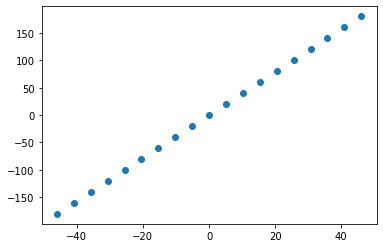

In [44]:
plt.scatter(xts, yts)
plt.scatter()

In [45]:
print(nframes)

19
